# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.259177,False,-0.908811
1,-1.217482,False,-3.337837
2,1.596389,True,10.081653
3,1.742959,True,10.200651
4,0.738901,True,7.021674
...,...,...,...
995,-0.266703,True,4.311289
996,1.030838,True,9.227912
997,0.067307,False,0.182366
998,-1.157805,False,-2.584106


<AxesSubplot:xlabel='v0'>

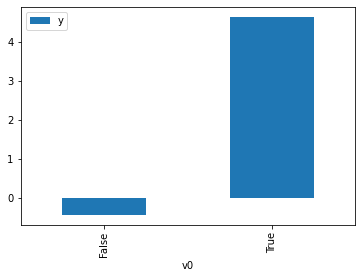

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

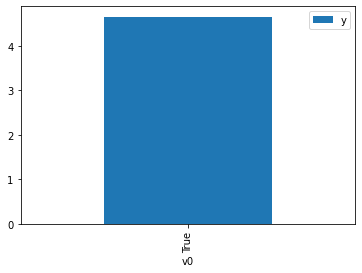

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.924300,False,-1.698171,0.707058,1.414311
1,-0.058899,False,0.425949,0.497546,2.009866
2,-1.195806,False,-2.124859,0.761453,1.313279
3,0.080706,False,1.201492,0.461689,2.165961
4,-0.554231,False,-2.311099,0.622493,1.606445
...,...,...,...,...,...
995,0.305905,False,1.398080,0.404827,2.470194
996,0.102170,False,-1.820377,0.456202,2.192013
997,-0.474058,False,-0.998808,0.602909,1.658625
998,-3.208118,False,-7.105793,0.962035,1.039463


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.267065,True,7.892920,0.798177,1.252855
1,1.246553,True,7.665516,0.794754,1.258252
2,0.478518,True,6.130661,0.637171,1.569438
3,-0.180794,True,6.142572,0.471113,2.122633
4,-2.056338,True,-1.258341,0.114396,8.741580
...,...,...,...,...,...
995,1.152061,True,9.300843,0.778430,1.284638
996,-1.613753,True,-0.586754,0.169250,5.908416
997,-1.284630,True,2.192241,0.222335,4.497711
998,2.245013,True,11.622917,0.915426,1.092387


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.958
Model:                            OLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                          1.133e+04
Date:                Mon, 01 Aug 2022   Prob (F-statistic):                        0.00
Time:                        07:45:37   Log-Likelihood:                         -1405.3
No. Observations:                1000   AIC:                                      2815.
Df Residuals:                     998   BIC:                                      2824.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4717      0.032     78.138      0.000       2.410       2.534
x2             5.0003      0.046    109.380      0.000       4.911       5.090
==============================================================================
Omnibus:                        2.071   Durbin-Watson:                   2.128
Prob(Omnibus):                  0.355   Jarque-Bera (JB):                2.045
Skew:                          -0.067   Prob(JB):                        0.360
Kurtosis:                       2.824   Cond. No.                         1.53
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""